# BALD Bayesian Active Leaning CNN
# IndianPines HSI dataset
# Date:  2023
# kkh



In [1]:
from sklearn.decomposition import PCA

from __future__ import print_function
from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD, Adadelta, Adagrad, Adam
from keras.utils import np_utils, generic_utils
from six.moves import range
import numpy as np
import scipy as sp
from keras import backend as K  
import random
import scipy.io
import matplotlib.pyplot as plt
from keras.regularizers import l2


DATA

In [2]:
## VARIABLES

test_ratio = 0.3
test_val_ratio=0.7

train_ratio = 1-test_ratio
#train_val_ratio = 0.8


windowSize = 7  #  25
dimReduction = 80 # dimReduction

drop = 0.4

In [3]:
# Read data
from sklearn.model_selection import train_test_split

from scipy.io import loadmat

def read_HSI():
  X = loadmat('Indian_pines.mat')['indian_pines']
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()


# PCA
def applyPCA(X, numComponents): # numComponents=64
    newX = np.reshape(X, (-1, X.shape[2]))
    print(newX.shape)
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca, pca.explained_variance_ratio_

# pading With Zeros
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]),dtype="float16")
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

# Split Data

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,stratify=y)
    return X_train, X_test, y_train, y_test

X shape: (145, 145, 220)
y shape: (145, 145)


In [4]:
# Split the hyperspectral image into patches of size windowSize-by-windowSize pixels
def Patches_Creating(X, y, windowSize, removeZeroLabels = True):  # windowSize=15, 25
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]),dtype="float16")
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]),dtype="float16")
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels
# channel_wise_shift
def channel_wise_shift(X,numComponents):
    X_copy = np.zeros((X.shape[0] , X.shape[1], X.shape[2]))
    half = int(numComponents/2)
    for i in range(0,half-1):
        X_copy[:,:,i] = X[:,:,(half-i)*2-1]
    for i in range(half,numComponents):
        X_copy[:,:,i] = X[:,:,(i-half)*2]
    X = X_copy
    return X

In [5]:
#(X_train_All, y_train_All), (X_test, y_test) = mnist.load_data()

Experiments = 3

batch_size = 128
nb_classes = 16

#use a large number of epochs
nb_epoch = 20

# input image dimensions
img_rows, img_cols = 28, 28
# number of convolutional filters to use
nb_filters = 32
# size of pooling area for max pooling
nb_pool = 1

# Original Kernel Size used in all other experiments: nb_conv = 3

# convolution kernel size
nb_conv = 1

score=0
all_accuracy = 0
acquisition_iterations = 98

#use a large number of dropout iterations
dropout_iterations = 50

Queries = 16


Experiments_All_Accuracy = np.zeros(shape=(acquisition_iterations+1))

In [6]:
X0, y0 = read_HSI()
#X=X0
#y=y0

InputShape=(windowSize, windowSize, dimReduction)

#X, y = loadData(dataset) channel_wise_shift
X1,pca,ratio = applyPCA(X0,numComponents=dimReduction)
X2_shifted = channel_wise_shift(X1,dimReduction) # channel-wise shift
#X2=X1

#print(f"X0 shape: {X0.shape}\ny0 shape: {y0.shape}")
#print(f"X1 shape: {X1.shape}\nX2 shape: {X2.shape}")

X3, y3 = Patches_Creating(X2_shifted, y0, windowSize=windowSize)  # 5 for PAvia Center

Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X3, y3, test_ratio)


Xtest0=Xtest
ytest0=ytest

Xtrain = Xtrain.reshape(-1, windowSize,windowSize, dimReduction)


ytrain = np_utils.to_categorical(ytrain)

Xvalid, Xtest, yvalid, ytest = splitTrainTestSet(Xtest, ytest, test_val_ratio)

ytest = np_utils.to_categorical(ytest)


Xvalid = Xvalid.reshape(-1, windowSize,windowSize, dimReduction)
yvalid = np_utils.to_categorical(yvalid)

print(f"Xtrain shape: {Xtrain.shape}\nytrain shape : {ytrain.shape}")

# Xtrain ytrain   Xtest  ytest    Xvalid yvalid

X shape: (145, 145, 220)
y shape: (145, 145)
(21025, 220)
Xtrain shape: (7174, 7, 7, 80)
ytrain shape : (7174, 16)


In [7]:
# Testing Model_ N02
# Basian deep neural network (BCNN)
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

tfd = tfp.distributions
tfpl = tfp.layers
# Testing Model_ N02
# Basian deep neural network (BCNN)

divergence_fn = lambda q,p,_:tfd.kl_divergence(q,p)/len(Xtrain)   #3457

# BCNN model
#
model_bayes = Sequential([
    # Statistical 2D conv
    tfpl.Convolution2DReparameterization(input_shape=InputShape, filters=32, kernel_size=3, activation='relu',
                                           kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                           kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           kernel_divergence_fn = divergence_fn,
                                           bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                           bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                           bias_divergence_fn = divergence_fn),
    MaxPooling2D(2,1),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,1),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    # Statistical Dense-
    tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(16), activation=None,
                                    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
                                    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    kernel_divergence_fn = divergence_fn,
                                    bias_prior_fn = tfpl.default_multivariate_normal_fn,
                                    bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                    bias_divergence_fn = divergence_fn
                                ),
    # output-
    tfpl.OneHotCategorical(16)
    
])
model_bayes.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_reparameterization (  (None, 5, 5, 32)         46144     
 Conv2DReparameterization)                                       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 32)         0         


c:\Users\kifah\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\layers\util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
c:\Users\kifah\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_probability\python\layers\util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 2, 2, 32)          9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 512)               16896     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_reparameterization (D  (None, 16)               16416     
 enseReparameterization)                                         
          

In [8]:
#Testing Model_ N01
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

def negative_log_likelihood(y_true, y_pred):
    return -y_pred.log_prob(y_true)

# Testing Model_ N02
# Comiple

model_bayes.compile(loss = negative_log_likelihood,
              optimizer = Adam(learning_rate=0.001), #0.005
              metrics = ['accuracy'],
              experimental_run_tf_function = False)

In [9]:
for e in range(3):

	print('Experiment Number ', e)

	# the data, shuffled and split between tran and test sets

	#X_train_All = X_train_All.reshape(X_train_All.shape[0], 1, img_rows, img_cols)
	#X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)

	X_train_All=Xtrain
	y_train_All=ytrain
	y_test=ytest
	X_test=Xtest

	## Xtrain ytrain   Xtest  ytest    Xvalid yvalid

	
	#X_valid = X_train_All[6000:7174, :, :, :]
	#y_valid = y_train_All[6000:7174]
	X_valid=Xvalid
	y_valid=yvalid


	X_Pool = X_train_All[5000:7174, :, :, :]
	y_Pool = y_train_All[5000:7174]


	X_train_All = X_train_All[0:5000, :, :, :]
	y_train_All = y_train_All[0:5000]


	ssz=20


	idx_0 = np.array( np.where(y_train_All==0)  ).T
	idx_0 = idx_0[0:ssz,0]
	X_0 = X_train_All[idx_0, :, :, :]
	y_0 = y_train_All[idx_0]

	idx_1 = np.array( np.where(y_train_All==1)  ).T
	idx_1 = idx_1[0:ssz,0]
	X_1 = X_train_All[idx_1, :, :, :]
	y_1 = y_train_All[idx_1]

	idx_2 = np.array( np.where(y_train_All==2)  ).T
	idx_2 = idx_2[0:ssz,0]
	X_2 = X_train_All[idx_2, :, :, :]
	y_2 = y_train_All[idx_2]

	idx_3 = np.array( np.where(y_train_All==3)  ).T
	idx_3 = idx_3[0:ssz,0]
	X_3 = X_train_All[idx_3, :, :, :]
	y_3 = y_train_All[idx_3]

	idx_4 = np.array( np.where(y_train_All==4)  ).T
	idx_4 = idx_4[0:ssz,0]
	X_4 = X_train_All[idx_4, :, :, :]
	y_4 = y_train_All[idx_4]

	idx_5 = np.array( np.where(y_train_All==5)  ).T
	idx_5 = idx_5[0:ssz,0]
	X_5 = X_train_All[idx_5, :, :, :]
	y_5 = y_train_All[idx_5]

	idx_6 = np.array( np.where(y_train_All==6)  ).T
	idx_6 = idx_6[0:ssz,0]
	X_6 = X_train_All[idx_6, :, :, :]
	y_6 = y_train_All[idx_6]

	idx_7 = np.array( np.where(y_train_All==7)  ).T
	idx_7 = idx_7[0:ssz,0]
	X_7 = X_train_All[idx_7, :, :, :]
	y_7 = y_train_All[idx_7]

	idx_8 = np.array( np.where(y_train_All==8)  ).T
	idx_8 = idx_8[0:ssz,0]
	X_8 = X_train_All[idx_8, :, :, :]
	y_8 = y_train_All[idx_8]

	idx_9 = np.array( np.where(y_train_All==9)  ).T
	idx_9 = idx_9[0:ssz,0]
	X_9 = X_train_All[idx_9, :, :, :]
	y_9 = y_train_All[idx_9]

	idx_10 = np.array( np.where(y_train_All==10)  ).T
	idx_10 = idx_10[0:ssz,0]
	X_10 = X_train_All[idx_10, :, :, :]
	y_10 = y_train_All[idx_10]

	idx_11 = np.array( np.where(y_train_All==11)  ).T
	idx_11 = idx_11[0:ssz,0]
	X_11 = X_train_All[idx_11, :, :, :]
	y_11 = y_train_All[idx_11]

	idx_12 = np.array( np.where(y_train_All==12)  ).T
	idx_12 = idx_12[0:ssz,0]
	X_12 = X_train_All[idx_12, :, :, :]
	y_12 = y_train_All[idx_12]
	

	idx_13 = np.array( np.where(y_train_All==13)  ).T
	idx_13 = idx_13[0:ssz,0]
	X_13 = X_train_All[idx_13, :, :, :]
	y_13 = y_train_All[idx_13]

	idx_14 = np.array( np.where(y_train_All==14)  ).T
	idx_14 = idx_14[0:ssz,0]
	X_14 = X_train_All[idx_14, :, :, :]
	y_14 = y_train_All[idx_14]

	idx_15 = np.array( np.where(y_train_All==15)  ).T
	idx_15 = idx_15[0:ssz,0]
	X_15 = X_train_All[idx_15, :, :, :]
	y_15 = y_train_All[idx_15]



	X_train = np.concatenate(( X_0, X_1, X_2, X_3, X_4, X_5, X_6, X_7, X_8, X_9,X_10,X_11,X_12,X_13,X_14,X_15), axis=0 )
	y_train = np.concatenate(( y_0, y_1, y_2, y_3, y_4, y_5, y_6, y_7, y_8, y_9,y_10,y_11,y_12,y_13,y_14,y_15), axis=0 )


	print('X_train shape:', X_train.shape)
	print(X_train.shape[0], 'train samples')

    # here to put
	X_train = X_train.astype('float32')
	X_test = X_test.astype('float32')
	X_valid = X_valid.astype('float32')
	X_Pool = X_Pool.astype('float32')
	X_train /= 255
	X_valid /= 255
	X_Pool /= 255
	X_test /= 255


	Y_test = np_utils.to_categorical(y_test, nb_classes)
	Y_valid = np_utils.to_categorical(y_valid, nb_classes)
	Y_Pool = np_utils.to_categorical(y_Pool, nb_classes)


	#loss values in each experiment
	Pool_Valid_Loss = np.zeros(shape=(nb_epoch, 1)) 	
	Pool_Train_Loss = np.zeros(shape=(nb_epoch, 1)) 
	Pool_Valid_Acc = np.zeros(shape=(nb_epoch, 1)) 	
	Pool_Train_Acc = np.zeros(shape=(nb_epoch, 1)) 
	x_pool_All = np.zeros(shape=(1))

	Y_train = np_utils.to_categorical(y_train, nb_classes)

	print('Training Model Without Acquisitions in Experiment', e)
	
    #Xvalid, yvalid
		
	#model_bayes.compile(loss=negative_log_likelihood, optimizer='adam', metrics='accuracy')
	#hist = model_bayes.fit(X_train, Y_train, batch_size=batch_size, epochs =nb_epoch, validation_data=(X_valid, Y_valid))
	hist = model_bayes.fit(Xtrain, ytrain, batch_size=batch_size, epochs =nb_epoch, validation_data=(Xvalid, yvalid))

    #loss, accuracy = model.evaluate(test_X, test_y_ohe, verbose=0)
	
	Train_Result_Optimizer = hist.history
	Train_Loss = np.asarray(Train_Result_Optimizer.get('loss'))
	Train_Loss = np.array([Train_Loss]).T
	Valid_Loss = np.asarray(Train_Result_Optimizer.get('val_loss'))
	Valid_Loss = np.asarray([Valid_Loss]).T
	Train_Acc = np.asarray(Train_Result_Optimizer.get('acc'))
	Train_Acc = np.array([Train_Acc]).T
	Valid_Acc = np.asarray(Train_Result_Optimizer.get('val_acc'))
	Valid_Acc = np.asarray([Valid_Acc]).T


	Pool_Train_Loss = Train_Loss
	Pool_Valid_Loss = Valid_Loss
	Pool_Train_Acc = Train_Acc
	Pool_Valid_Acc = Valid_Acc
	
    # Xtrain ytrain   Xtest  ytest    Xvalid yvalid
	print('Evaluating Test Accuracy Without Acquisition')
	score, acc = model_bayes.evaluate(Xtest, ytest,  verbose=0)

	all_accuracy = acc

	print('Starting Active Learning in Experiment ', e)



	for i in range(3): # acquisition_iterations
		
		print('POOLING ITERATION', i)

		#take subset of Pool Points for Test Time Dropout 
		#and do acquisition from there
		pool_subset = 500
		pool_subset_dropout = np.asarray(random.sample(range(0,X_Pool.shape[0]), pool_subset))
		X_Pool_Dropout = X_Pool[pool_subset_dropout, :, :, :]
		y_Pool_Dropout = y_Pool[pool_subset_dropout]

		score_All = np.zeros(shape=(X_Pool_Dropout.shape[0], nb_classes))
		All_Entropy_Dropout = np.zeros(shape=X_Pool_Dropout.shape[0])

		for d in range(dropout_iterations):
			print ('Dropout Iteration', d)  
			dropout_score = model_bayes.predict(X_Pool_Dropout,batch_size=batch_size, verbose=1)
			#dropout_score = np_utils.to_categorical(y_Pool, nb_classes)


			#computing G_X
			score_All = score_All + dropout_score

			#computing F_X
			dropout_score_log = np.log2(dropout_score+2)
			Entropy_Compute = - np.multiply(dropout_score, dropout_score_log)
			Entropy_Per_Dropout = np.sum(Entropy_Compute, axis=1)

			All_Entropy_Dropout = All_Entropy_Dropout + Entropy_Per_Dropout 


		Avg_Pi = np.divide(score_All, dropout_iterations)
		Log_Avg_Pi = np.log2(Avg_Pi+2)
		Entropy_Avg_Pi = - np.multiply(Avg_Pi, Log_Avg_Pi)
		Entropy_Average_Pi = np.sum(Entropy_Avg_Pi, axis=1)

		G_X = Entropy_Average_Pi

		Average_Entropy = np.divide(All_Entropy_Dropout, dropout_iterations)

		F_X = Average_Entropy

		U_X = G_X - F_X

		# THIS FINDS THE MINIMUM INDEX 
		# a_1d = U_X.flatten()
		# x_pool_index = a_1d.argsort()[-Queries:]

		a_1d = U_X.flatten()
		x_pool_index = a_1d.argsort()[-Queries:][::-1]


		#store all the pooled images indexes
		x_pool_All = np.append(x_pool_All, x_pool_index)

		#saving pooled images
		
		Pooled_X = X_Pool_Dropout[x_pool_index, :, :, :]
		Pooled_Y = y_Pool_Dropout[x_pool_index]	

		#first delete the random subset used for test time dropout from X_Pool
		#Delete the pooled point from this pool set (this random subset)
		#then add back the random pool subset with pooled points deleted back to the X_Pool set

		delete_Pool_X = np.delete(X_Pool, (pool_subset_dropout), axis=0)
		delete_Pool_Y = np.delete(y_Pool, (pool_subset_dropout), axis=0)

		delete_Pool_X_Dropout = np.delete(X_Pool_Dropout, (x_pool_index), axis=0)
		delete_Pool_Y_Dropout = np.delete(y_Pool_Dropout, (x_pool_index), axis=0)

		X_Pool = np.concatenate((delete_Pool_X, delete_Pool_X_Dropout), axis=0)
		y_Pool = np.concatenate((delete_Pool_Y, delete_Pool_Y_Dropout), axis=0)


		print('Acquised Points added to training set')
		X_train = np.concatenate((X_train, Pooled_X), axis=0)
		y_train = np.concatenate((y_train, Pooled_Y), axis=0)


		# convert class vectors to binary class matrices

		Y_train = np_utils.to_categorical(y_train, nb_classes)
		
		#Xtrain, ytrain, ytest,Xtest   Xvalid, yvalid
	

		#model_bayes.compile(loss=negative_log_likelihood, optimizer='adam',metrics='accuracy')
		#hist = model_bayes.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_valid, Y_valid))
		hist = model_bayes.fit(Xtrain, ytrain, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(Xvalid, yvalid))

		Train_Result_Optimizer = hist.history
		Train_Loss = np.asarray(Train_Result_Optimizer.get('loss'))
		Train_Loss = np.array([Train_Loss]).T
		Valid_Loss = np.asarray(Train_Result_Optimizer.get('val_loss'))
		Valid_Loss = np.asarray([Valid_Loss]).T
		Train_Acc = np.asarray(Train_Result_Optimizer.get('acc'))
		Train_Acc = np.array([Train_Acc]).T
		Valid_Acc = np.asarray(Train_Result_Optimizer.get('val_acc'))
		Valid_Acc = np.asarray([Valid_Acc]).T

		#Accumulate the training and validation/test loss after every pooling iteration - for plotting

		Pool_Valid_Loss = np.append(Pool_Valid_Loss, Valid_Loss, axis=1)
		Pool_Train_Loss = np.append(Pool_Train_Loss, Train_Loss, axis=1)

		print('Evaluate Model Test Accuracy with pooled points')

		#score, acc = model_bayes.evaluate(X_test, Y_test , verbose=0)
		score, acc = model_bayes.evaluate(Xtest, ytest , verbose=1)

		print('Test score:', score)
		print('Test accuracy:', acc)
		all_accuracy = np.append(all_accuracy, acc)

		print('Use this trained model with pooled points for Dropout again')


	print('Storing Accuracy Values over experiments')
	Experiments_All_Accuracy =  all_accuracy




Experiment Number  0
X_train shape: (40, 7, 7, 80)
40 train samples
Training Model Without Acquisitions in Experiment 0
Epoch 1/20
57/57 [==============================] - 2s 18ms/step - loss: 12.9481 - accuracy: 0.2774 - val_loss: 11.9594 - val_accuracy: 0.5358
Epoch 2/20
57/57 [==============================] - 1s 18ms/step - loss: 11.6220 - accuracy: 0.6583 - val_loss: 11.3386 - val_accuracy: 0.7516
Epoch 3/20
57/57 [==============================] - 1s 13ms/step - loss: 11.1555 - accuracy: 0.8173 - val_loss: 11.0267 - val_accuracy: 0.8557
Epoch 4/20
57/57 [==============================] - 1s 12ms/step - loss: 10.9267 - accuracy: 0.8793 - val_loss: 10.8309 - val_accuracy: 0.9002
Epoch 5/20
57/57 [==============================] - 1s 15ms/step - loss: 10.7345 - accuracy: 0.9235 - val_loss: 10.6655 - val_accuracy: 0.9295
Epoch 6/20
57/57 [==============================] - 1s 13ms/step - loss: 10.5775 - accuracy: 0.9501 - val_loss: 10.5577 - val_accuracy: 0.9338
Epoch 7/20
57/57 [====

In [10]:
Average_Accuracy = np.average(Experiments_All_Accuracy)
print(Average_Accuracy)
#np.save('/home/ri258/Documents/Project/MPhil_Thesis_Cluster_Experiments/ConvNets/Cluster_Experiments/Final_Experiments/Results/'+'Dropout_Bald_Q10_N1000_Average_Accuracy'+'.npy', Average_Accuracy)


0.9775893986225128


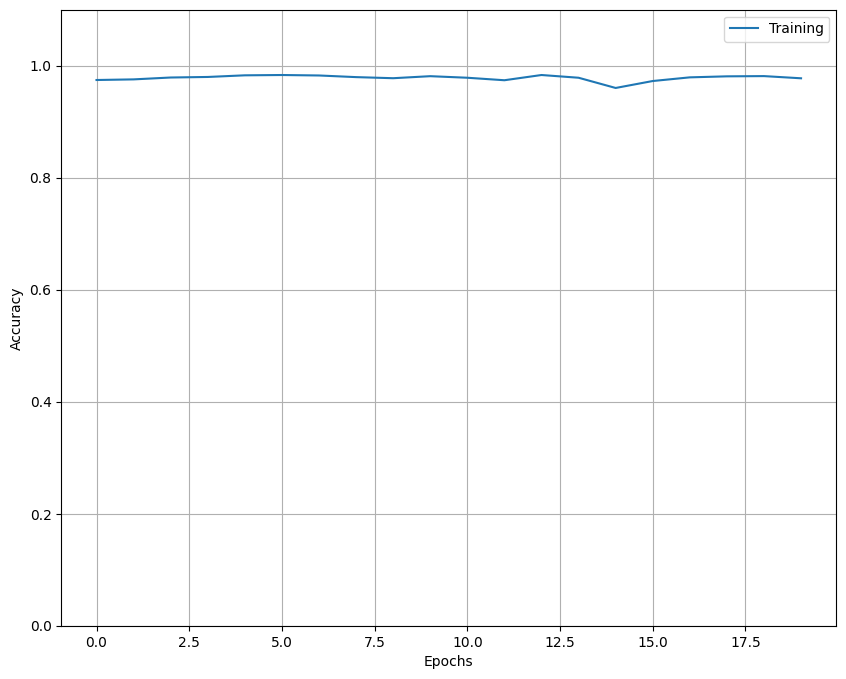

In [11]:
# Plot accuracy
plt.figure(figsize=(10,8))
plt.ylim(0,1.1)
plt.grid()
plt.plot(hist.history['accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

In [12]:
# 16 classes


names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn', 'Grass-pasture', 'Grass-trees', 
         'Grass-pasture-mowed', 'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
           'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives', 'Stone-Steel-Towers']

97/97 [==============================] - 0s 2ms/step


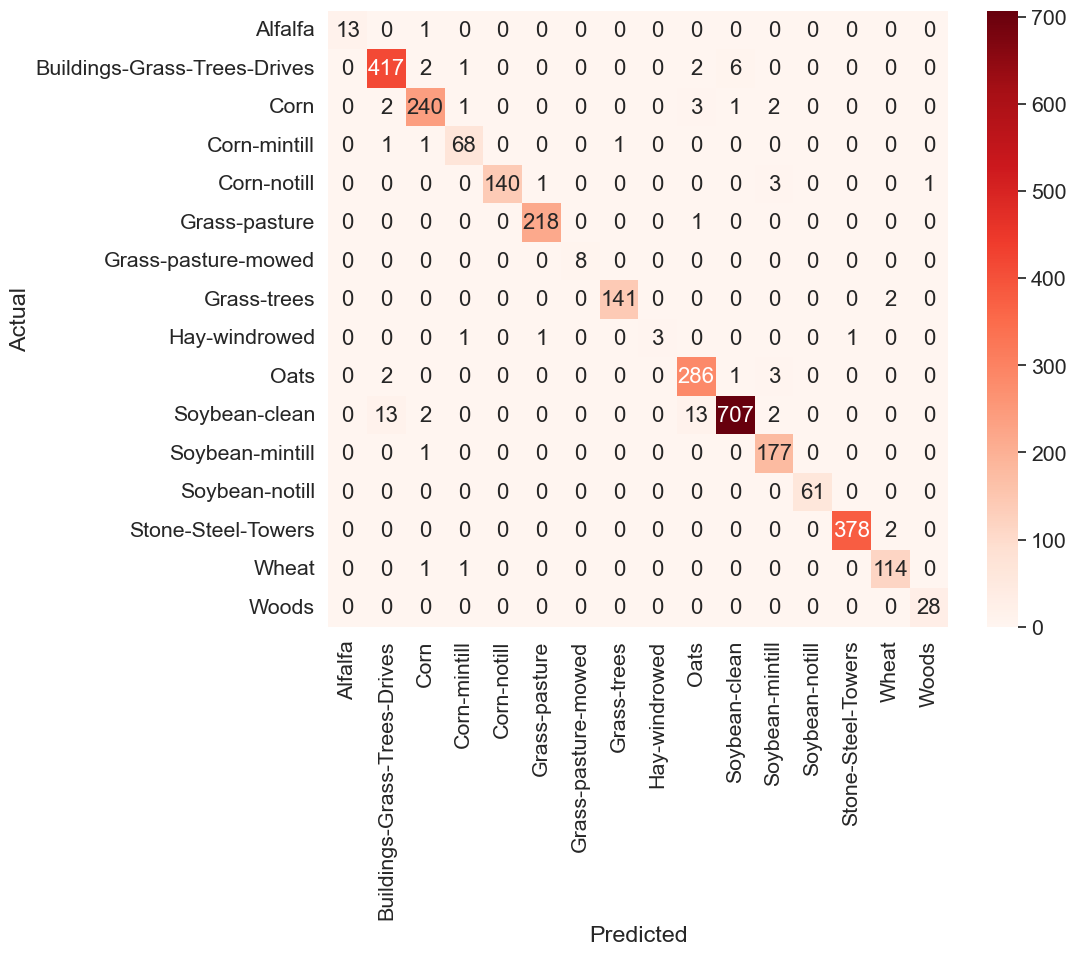

In [13]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
import pandas as pd
import numpy as np
import seaborn as sn
# confusion_matrix
Y_pred = model_bayes.predict(Xtest0)
y_pred = np.argmax(Y_pred, axis=1)

confusion = confusion_matrix(ytest0, y_pred)
df_cm = pd.DataFrame(confusion, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [14]:
# average_acc
from operator import itemgetter
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num((list_diag/ list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [15]:
# average_acc

each_acc, aa = AA_andEachClassAccuracy(confusion)
print("accuracy for each:")
print (each_acc)

print("OA accuracy:")
print(aa)

accuracy for each:
[0.92857143 0.97429907 0.96385542 0.95774648 0.96551724 0.99543379
 1.         0.98601399 0.5        0.97945205 0.95929444 0.99438202
 1.         0.99473684 0.98275862 1.        ]
OA accuracy:
0.9488788368042085


In [16]:
# classification_report
print(classification_report(ytest0, y_pred, target_names = names, digits = 3))

                              precision    recall  f1-score   support

                     Alfalfa      1.000     0.929     0.963        14
                 Corn-notill      0.959     0.974     0.966       428
                Corn-mintill      0.968     0.964     0.966       249
                        Corn      0.944     0.958     0.951        71
               Grass-pasture      1.000     0.966     0.982       145
                 Grass-trees      0.991     0.995     0.993       219
         Grass-pasture-mowed      1.000     1.000     1.000         8
               Hay-windrowed      0.993     0.986     0.989       143
                        Oats      1.000     0.500     0.667         6
              Soybean-notill      0.938     0.979     0.958       292
             Soybean-mintill      0.989     0.959     0.974       737
               Soybean-clean      0.947     0.994     0.970       178
                       Wheat      1.000     1.000     1.000        61
                   